In [0]:
#я не торч просто дунул
import torch
import time

import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [0]:
class LambdaLayer(torch.nn.Module):
  def __init__(self, lambda_):
    super(LambdaLayer, self).__init__()
    self.lambda_ = lambda_
    
    def forward(self, x):
      x = self.lambda_(x)
      return x
    
class BasicBlock(torch.nn.Module):
  def __init__(self, in_channels, out_channels, stride=1, option='B',
               use_batch_norm=True, use_drop_out=False, d_out_p=0.5):
    super(BasicBlock, self).__init__()
    
    self.use_batch_norm = use_batch_norm
    self.use_drop_out = use_drop_out
    self.d_out_p = d_out_p
    
    self.act = torch.nn.ReLU()
    self.conv1 = torch.nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                 kernel_size=3, stride=stride, padding=1, bias=False)
    self.bn1 = torch.nn.BatchNorm2d(num_features=out_channels)
    self.d_out1 = torch.nn.Dropout2d(self.d_out_p)
    
    self.conv2 = torch.nn.Conv2d(in_channels=out_channels, out_channels=out_channels,
                                 kernel_size=3, stride=1, padding=1, bias=False)
    self.bn2 = torch.nn.BatchNorm2d(num_features=out_channels)
    self.d_out2 = torch.nn.Dropout2d(self.d_out_p)
    
    self.shortcut = torch.nn.Sequential()
    if stride != 1 or in_channels != out_channels:
      if option == 'A':
        self.shortcut = LambdaLayer(lambda x: torch.nn.functional.pad(
                                    x[:, :, ::2, ::2], (0, 0, 0, 0, out_channels // 4, out_channels // 4),
                                    "constant", 0))
      elif option == 'B':
        self.shortcut = torch.nn.Sequential(
                         torch.nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                         kernel_size=1, stride=stride, padding=0, bias=False),
                         torch.nn.BatchNorm2d(num_features=out_channels))
  
  def forward(self, x):
    out = self.conv1(x)
    if self.use_batch_norm:
      out = self.bn1(out)
    if self.use_drop_out:
      out = self.d_out1(out)
    out = self.act(out)
    
    out = self.conv2(out)
    if self.use_batch_norm:
      out = self.bn2(out)
    if self.use_drop_out:
      out = self.d_out2(out)
    out = self.act(out)
    
    out += self.shortcut(x)
    out = self.act(out)
    
    return out

class ResNet(torch.nn.Module):
  def __init__(self, block, n_blocks_per_layer, use_batch_norm=True,
               use_drop_out=False, d_out_p=0.5):
    super(ResNet, self).__init__()
    
    self.use_batch_norm = use_batch_norm
    self.use_drop_out = use_drop_out
    self.d_out_p = d_out_p
    self.in_channels = 16
    
    self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1, stride=1)
    self.bn1 = torch.nn.BatchNorm2d(num_features=16)
    self.d_out1 = torch.nn.Dropout2d(self.d_out_p)
    
    self.layer1 = self._make_layer(block=block, in_channels=16, out_channels=16, n_blocks=n_blocks_per_layer[0], stride=1)
    self.layer2 = self._make_layer(block=block, in_channels=16, out_channels=32, n_blocks=n_blocks_per_layer[1], stride=2)
    self.layer3 = self._make_layer(block=block, in_channels=32, out_channels=64, n_blocks=n_blocks_per_layer[2], stride=2)
    
    self.pool = torch.nn.AvgPool2d(stride=2, kernel_size=2)
    
    self.fc = torch.nn.Linear(1024, 10)
    
  def _make_layer(self, block, in_channels, out_channels, n_blocks, stride):
    strides = [stride] + [1]*(n_blocks - 1)
    layers = []
    
    for stride in strides:
      layers.append(block(in_channels=self.in_channels, out_channels=out_channels,
                          stride=stride, use_batch_norm=self.use_batch_norm,
                          use_drop_out=self.use_drop_out, d_out_p=self.d_out_p))
      self.in_channels = out_channels
    return torch.nn.Sequential(*layers)
      
     
  def forward(self, x):
    out = self.conv1(x)
    if self.use_batch_norm:
      out = self.bn1(out)
    if self.use_drop_out:
      out = self.d_out1(out)
    
    out = self.layer1(out)
    out = self.layer2(out)
    out = self.layer3(out)
    
    out = self.pool(out)
    
    out = out.view(out.size(0), -1)
    out = self.fc(out)
    
    return out

In [0]:
import torchvision.datasets
CIFAR_train = torchvision.datasets.CIFAR10('./', download=True, train=True)
CIFAR_test = torchvision.datasets.CIFAR10('./', download=True, train=False)

X_train = torch.FloatTensor(CIFAR_train.data)
y_train = torch.LongTensor(CIFAR_train.targets)
X_test = torch.FloatTensor(CIFAR_test.data)
y_test = torch.LongTensor(CIFAR_test.targets)

X_train /= 255.
X_test /= 255.

X_train = X_train.permute(0, 3, 1, 2)
X_test = X_test.permute(0, 3, 1, 2)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
torch.cuda.is_available()

True

In [0]:
def accuracy(y_pred, y_true):
    return (y_pred == y_true).float().mean().data.cpu()


def train(net, x_train, y_train, x_test, y_test,
          n_epochs=100, batch_size=100, lr=1.0e-3, weight_decay=0,
          save_history=False, info_show_interval=3):
    
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    net.to(device)

    optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)
    loss = torch.nn.CrossEntropyLoss().to(device)
    
    x_test = x_test.to(device)
    y_test = y_test.to(device)
        
    test_accuracy_history = []
    test_loss_history = []

    t = time.time()
    for epoch in range(n_epochs):
        net.train()

        shuffled_indexes = np.random.permutation(x_train.shape[0])

        for start_index in range(0, x_train.shape[0], batch_size):
            optimizer.zero_grad()

            x_batch = x_train[shuffled_indexes[start_index:start_index + batch_size]].to(device)
            y_batch = y_train[shuffled_indexes[start_index:start_index + batch_size]].to(device)

            y_output = net.forward(x_batch)
            loss_value = loss(y_output, y_batch)
            loss_value.backward()
            optimizer.step()
            
        net.eval()
        
        with torch.no_grad():
            test_output = net.forward(x_test)
            test_accuracy_value = accuracy(test_output.argmax(dim=1), y_test).data.cpu().numpy()
            
            if save_history:
                test_loss_value = loss(test_output, y_test).data.cpu().numpy()
                test_accuracy_history.append(test_accuracy_value.item())
                test_loss_history.append(test_loss_value.item())

        if epoch % info_show_interval == 0:          
            print('Train epoch: {} Time: {} Accuracy: {}'
                  .format(epoch + 1, time.strftime("%H:%M:%S", time.gmtime(time.time() - t)), test_accuracy_value))
            
    return test_accuracy_history, test_loss_history
    

In [0]:
from torchvision.models import resnet18

accuracies = {}
losses = {}

accuracies['resnet18'], losses['resnet18'] =\
    train(resnet18(), X_train, y_train, X_test, y_test, n_epochs=35,
          save_history=True, info_show_interval=10)

Train epoch: 1 Time: 00:00:18 Accuracy: 0.36879998445510864
Train epoch: 11 Time: 00:03:17 Accuracy: 0.7536999583244324
Train epoch: 21 Time: 00:06:15 Accuracy: 0.7572000026702881
Train epoch: 31 Time: 00:09:13 Accuracy: 0.7530999779701233


In [0]:
def resnet20():
  return ResNet(BasicBlock, [3, 3, 3])
accuracies['resnet20'], losses['resnet20'] = train(resnet20(), X_train, y_train, X_test, y_test,
                 n_epochs=35, save_history=True, info_show_interval=10)

Train epoch: 1 Time: 00:00:13 Accuracy: 0.6603999733924866
Train epoch: 11 Time: 00:02:29 Accuracy: 0.7949999570846558
Train epoch: 21 Time: 00:04:45 Accuracy: 0.8066999912261963
Train epoch: 31 Time: 00:07:00 Accuracy: 0.8157999515533447


In [0]:
def resnet110():
  return ResNet(BasicBlock, [18, 18, 18])

accuracies['resnet110'], losses['resnet110'] = train(resnet110(), X_train, y_train, X_test, y_test,
                 n_epochs=35, batch_size=100, save_history=True, info_show_interval=10)

Train epoch: 1 Time: 00:01:20 Accuracy: 0.47519999742507935
Train epoch: 11 Time: 00:14:38 Accuracy: 0.8139999508857727
Train epoch: 21 Time: 00:27:56 Accuracy: 0.824999988079071
Train epoch: 31 Time: 00:41:13 Accuracy: 0.8245999813079834


In [0]:
def resnet110_no_bn():
  return ResNet(BasicBlock, [18, 18, 18], use_batch_norm=False)

accuracies['resnet110_no_bn'], losses['resnet110_no_bn'] = train(resnet110_no_bn(), X_train, y_train, X_test, y_test,
                 n_epochs=35, batch_size=64, save_history=True, info_show_interval=10)

Train epoch: 1 Time: 00:01:07 Accuracy: 0.4901999831199646
Train epoch: 11 Time: 00:12:13 Accuracy: 0.7809999585151672
Train epoch: 21 Time: 00:23:16 Accuracy: 0.772599995136261
Train epoch: 31 Time: 00:34:17 Accuracy: 0.774399995803833


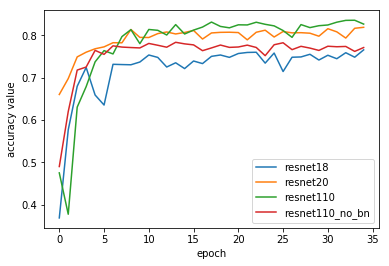

In [0]:
import matplotlib.pyplot as plt

for experiment_id in accuracies.keys():
  plt.plot(accuracies[experiment_id], label=experiment_id)
plt.xlabel('epoch')
plt.ylabel('accuracy value')
plt.legend();

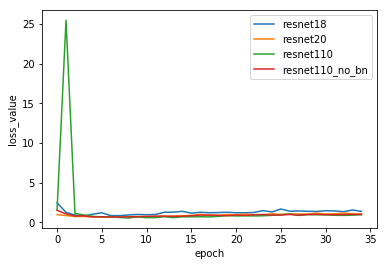

In [0]:
for experiment_id in losses.keys():
  plt.plot(losses[experiment_id], label=experiment_id)
plt.xlabel('epoch')
plt.ylabel('loss_value')
plt.legend();

In [0]:
accuracies = {}
losses = {}

In [0]:
def resnet20_d_out3():
  return ResNet(BasicBlock, [3, 3, 3], use_drop_out=True, d_out_p=.3)

accuracies['resnet20_d_out3'], losses['resnet20_d_out3'] = train(resnet20_d_out3(), X_train, y_train, X_test, y_test,
                 n_epochs=35, save_history=True, info_show_interval=10)

Train epoch: 1 Time: 00:00:14 Accuracy: 0.44119998812675476
Train epoch: 11 Time: 00:02:35 Accuracy: 0.7428999543190002
Train epoch: 21 Time: 00:04:57 Accuracy: 0.7847999930381775
Train epoch: 31 Time: 00:07:18 Accuracy: 0.7996999621391296


In [0]:
def resnet20_d_out5():
  return ResNet(BasicBlock, [3, 3, 3], use_drop_out=True)

accuracies['resnet20_d_out5'], losses['resnet20_d_out5'] = train(resnet20_d_out5(), X_train, y_train, X_test, y_test,
                 n_epochs=35, save_history=True, info_show_interval=10)

Train epoch: 1 Time: 00:00:14 Accuracy: 0.30889999866485596
Train epoch: 11 Time: 00:02:34 Accuracy: 0.5839999914169312
Train epoch: 21 Time: 00:04:54 Accuracy: 0.5922999978065491
Train epoch: 31 Time: 00:07:14 Accuracy: 0.6362000107765198


In [0]:
def resnet20_d_out15():
  return ResNet(BasicBlock, [3, 3, 3], use_drop_out=True, d_out_p=.15)

accuracies['resnet20_d_out15'], losses['resnet20_d_out15'] = train(resnet20_d_out5(), X_train, y_train, X_test, y_test,
                 n_epochs=35, save_history=True, info_show_interval=10)

Train epoch: 1 Time: 00:00:14 Accuracy: 0.3564999997615814
Train epoch: 11 Time: 00:02:34 Accuracy: 0.6087999939918518
Train epoch: 21 Time: 00:04:54 Accuracy: 0.6567999720573425
Train epoch: 31 Time: 00:07:14 Accuracy: 0.6922000050544739


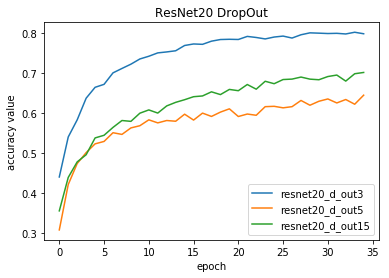

In [0]:
for experiment_id in accuracies.keys():
  plt.plot(accuracies[experiment_id], label=experiment_id)
plt.xlabel('epoch')
plt.ylabel('accuracy value')
plt.title('ResNet20 DropOut')
plt.legend();

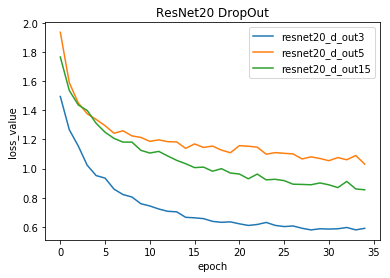

In [0]:
for experiment_id in losses.keys():
  plt.plot(losses[experiment_id], label=experiment_id)
plt.xlabel('epoch')
plt.ylabel('loss_value')
plt.title('ResNet20 DropOut')
plt.legend();

In [0]:
accuracies = {}
losses = {}

In [0]:
accuracies['resnet20 wd=1e-5'], losses['resnet20 wd=1e-5'] = \
    train(resnet20(), X_train, y_train, X_test, y_test, n_epochs=35, weight_decay=1e-5, save_history=True, info_show_interval=10)

Train epoch: 1 Time: 00:00:13 Accuracy: 0.6207999587059021
Train epoch: 11 Time: 00:02:30 Accuracy: 0.7653999924659729
Train epoch: 21 Time: 00:04:45 Accuracy: 0.8093000054359436
Train epoch: 31 Time: 00:07:01 Accuracy: 0.7968999743461609


In [0]:
accuracies['resnet20 wd=1e-3'], losses['resnet20 wd=1e-3'] = \
    train(resnet20(), X_train, y_train, X_test, y_test, n_epochs=35, weight_decay=1e-3, save_history=True, info_show_interval=10)

Train epoch: 1 Time: 00:00:13 Accuracy: 0.6072999835014343
Train epoch: 11 Time: 00:02:29 Accuracy: 0.8016999959945679
Train epoch: 21 Time: 00:04:44 Accuracy: 0.7782999873161316
Train epoch: 31 Time: 00:07:00 Accuracy: 0.7892999649047852


In [0]:
accuracies['resnet20 wd=1e-2'], losses['resnet20 wd=1e-2'] = \
    train(resnet20(), X_train, y_train, X_test, y_test, n_epochs=35, weight_decay=1e-2, save_history=True, info_show_interval=10)

Train epoch: 1 Time: 00:00:13 Accuracy: 0.5791000127792358
Train epoch: 11 Time: 00:02:28 Accuracy: 0.7215999960899353
Train epoch: 21 Time: 00:04:41 Accuracy: 0.7738999724388123
Train epoch: 31 Time: 00:06:54 Accuracy: 0.7793999910354614


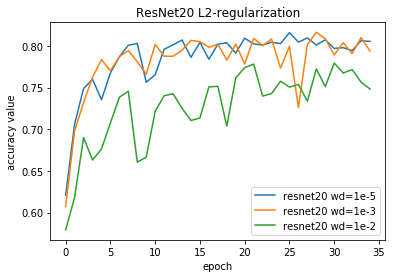

In [0]:
for experiment_id in accuracies.keys():
  plt.plot(accuracies[experiment_id], label=experiment_id)
plt.xlabel('epoch')
plt.ylabel('accuracy value')
plt.title('ResNet20 L2-regularization')
plt.legend();

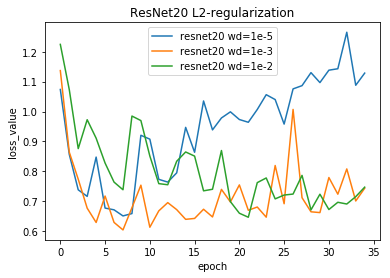

In [0]:
for experiment_id in losses.keys():
  plt.plot(losses[experiment_id], label=experiment_id)
plt.xlabel('epoch')
plt.ylabel('loss_value')
plt.title('ResNet20 L2-regularization')
plt.legend();